In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tracks_tagged = pd.read_csv('../data/tracks_tagged_v5.csv')
tracks_tagged

,id_track,id_site,id_m2,source,duration,alarm,min_speed,max_speed,avg_speed,curviness,...,repairs,distress,other,miss_ais,violation,le_contact,tdate,ttime,type_m2_agg,activity
0,29980760,10,18-0704-1000,radar,637,0,7.1,14.4,10.636634,1.023164,...,0,0,0,0,0,0,2023-07-04,10:06:47,NaN,NaN
1,30278317,10,158-0714-0950,radar,5463,1,0.1,6.7,3.016000,2.591425,...,0,0,0,0,0,0,2023-07-14,10:45:04,sail,drifting
2,30281714,10,196-0714-1032,radar,572,0,0.1,2.1,0.694318,1.300154,...,0,0,0,0,0,0,2023-07-14,10:43:06,NaN,NaN
3,30282211,10,1-0714-1040,radar,581,0,4.0,26.5,12.441758,1.068525,...,0,0,0,0,0,0,2023-07-14,10:42:50,NaN,NaN
4,31250251,10,63-0811-1036,radar,1379,1,0.7,13.7,10.932418,1.034715,...,0,0,0,0,0,0,2023-08-11,10:43:51,fishing_boat,transit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,42812042,45,5-1027-1120,radar,768,0,10.6,20.0,18.883486,1.005054,...,0,0,0,0,0,0,2024-12-19,12:24:26,NaN,NaN
4362,42812149,45,104-1027-1132,radar,2033,0,6.1,9.4,7.748220,1.004563,...,0,0,0,0,0,0,2024-12-19,12:24:30,NaN,NaN
4363,42812396,45,19-1027-1155,radar,758,0,5.9,9.6,7.920661,1.020434,...,0,0,0,0,0,0,2024-12-19,12:24:34,NaN,NaN
4364,42815993,45,66-1027-1728,radar,710,0,14.2,18.9,17.808850,1.002597,...,0,0,0,0,0,0,2024-12-19,12:25:03,NaN,NaN


In [3]:
tracks_tagged_small = tracks_tagged.dropna(subset=['activity'])
features_subset = ['min_speed', 'max_speed', 'avg_speed', 'curviness', 'heading_mean', 'heading_std', 'turning_mean', 'turning_std', 'duration_z', 'distance', 'distance_o']
X = tracks_tagged_small[features_subset]
y = tracks_tagged_small['activity']

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

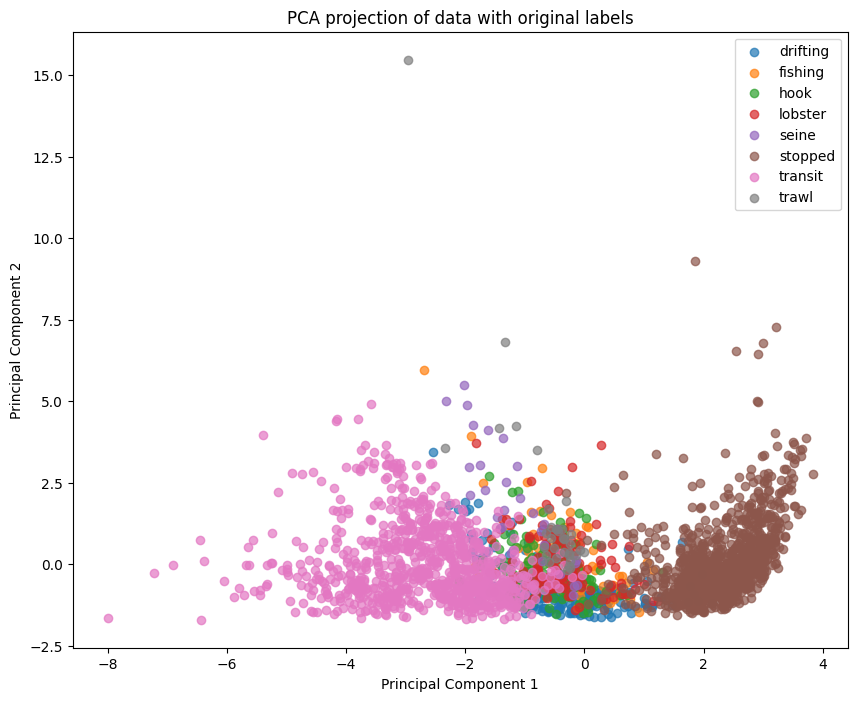

In [6]:
plt.figure(figsize=(10, 8))
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.7)
plt.title('PCA projection of data with original labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [7]:
from sklearn.cluster import KMeans

n_classes = len(np.unique(y))
kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

In [8]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

ari = adjusted_rand_score(y_encoded, cluster_labels)
nmi = normalized_mutual_info_score(y_encoded, cluster_labels)
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f"Clustering with {n_classes} clusters (same as number of classes):")
print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

Clustering with 8 clusters (same as number of classes):
ARI: 0.287
NMI: 0.425
Silhouette Score: 0.250


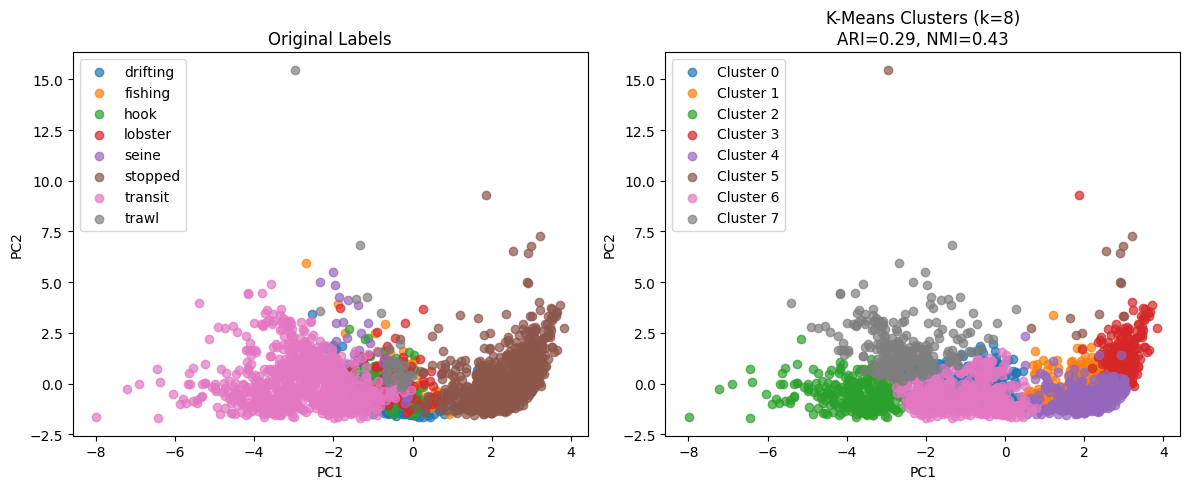

In [9]:
# Step 6: Visualize clustering results
plt.figure(figsize=(12, 5))

# Plot original labels
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.7)
plt.title('Original Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot cluster assignments
plt.subplot(1, 2, 2)
for i in range(n_classes):
    mask = (cluster_labels == i)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {i}', alpha=0.7)
plt.title(f'K-Means Clusters (k={n_classes})\nARI={ari:.2f}, NMI={nmi:.2f}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Step 7: Elbow method to find optimal number of clusters
wcss = []
ari_scores = []
nmi_scores = []
silhouette_scores = []
cluster_range = range(2, min(len(X), 15))  # Try up to 15 clusters

for k in cluster_range:
    # Apply K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Get cluster labels
    labels = kmeans.labels_

    # Calculate metrics
    wcss.append(kmeans.inertia_)
    ari_scores.append(adjusted_rand_score(y_encoded, labels))
    nmi_scores.append(normalized_mutual_info_score(y_encoded, labels))

    # Silhouette score can fail if a cluster has only one sample
    try:
        silhouette_scores.append(silhouette_score(X_scaled, labels))
    except:
        silhouette_scores.append(0)

    print(f"Clusters: {k}, ARI: {ari_scores[-1]:.3f}, NMI: {nmi_scores[-1]:.3f}")

Clusters: 2, ARI: 0.610, NMI: 0.559
Clusters: 3, ARI: 0.614, NMI: 0.586
Clusters: 4, ARI: 0.596, NMI: 0.579
Clusters: 5, ARI: 0.579, NMI: 0.532
Clusters: 6, ARI: 0.400, NMI: 0.485
Clusters: 7, ARI: 0.268, NMI: 0.449
Clusters: 8, ARI: 0.287, NMI: 0.425
Clusters: 9, ARI: 0.310, NMI: 0.450
Clusters: 10, ARI: 0.303, NMI: 0.452
Clusters: 11, ARI: 0.300, NMI: 0.447
Clusters: 12, ARI: 0.241, NMI: 0.435
Clusters: 13, ARI: 0.234, NMI: 0.432
Clusters: 14, ARI: 0.234, NMI: 0.434


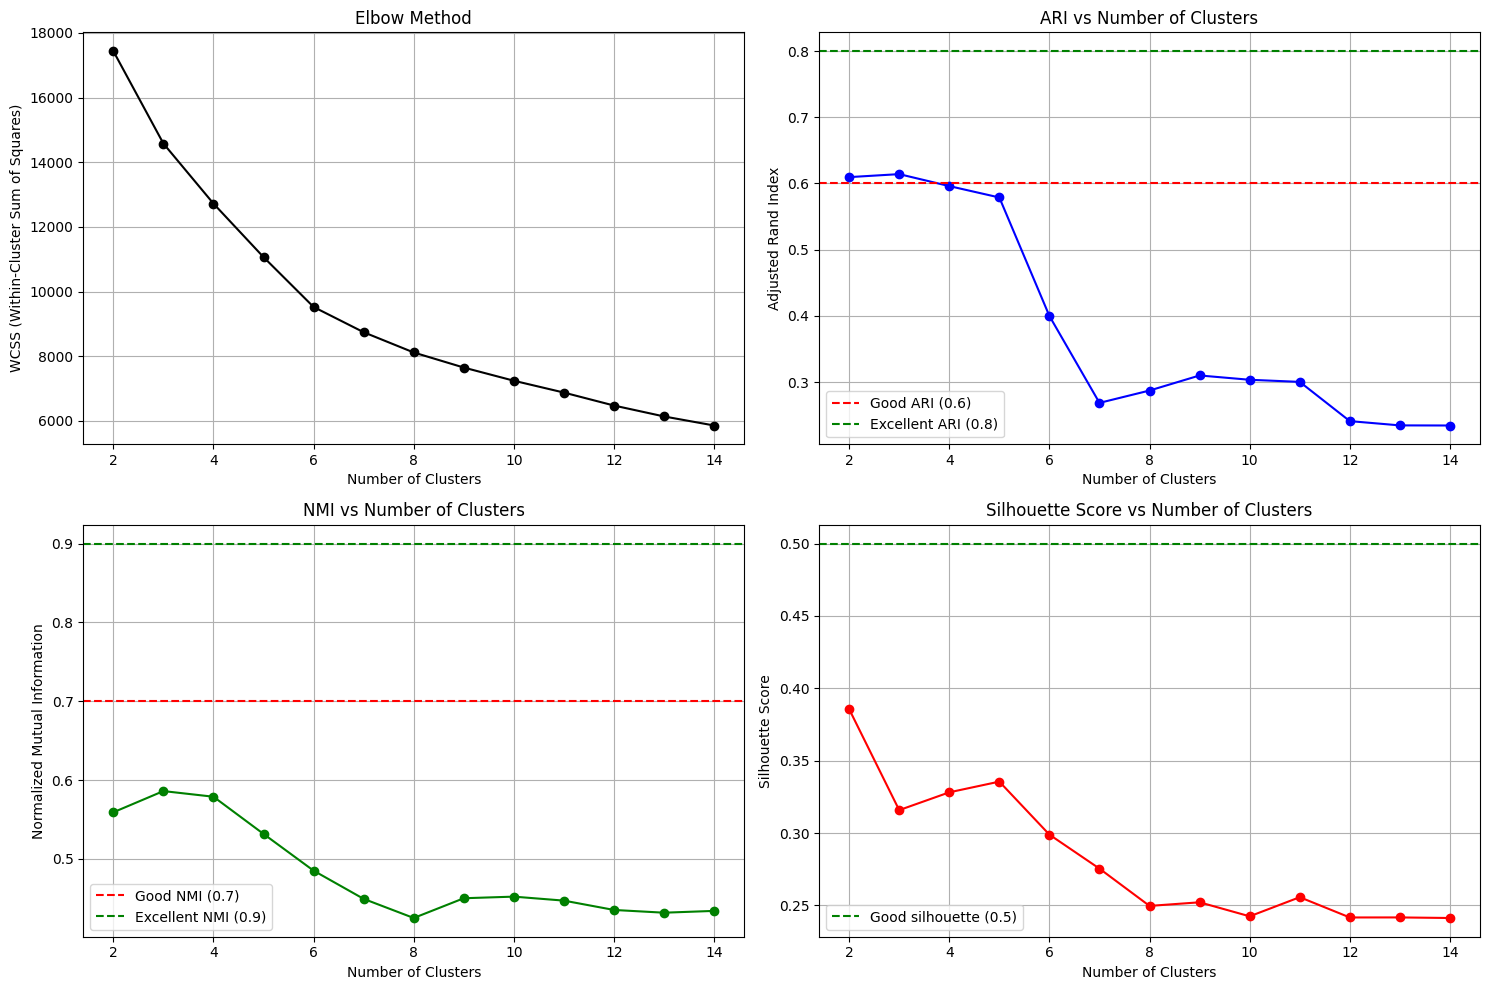

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on ARI: 3
Optimal number of clusters based on NMI: 3
True number of classes: 8


In [11]:
# Step 8: Plot the evaluation curves
plt.figure(figsize=(15, 10))

# Elbow curve
plt.subplot(2, 2, 1)
plt.plot(cluster_range, wcss, 'o-', color='black')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)

# ARI curve
plt.subplot(2, 2, 2)
plt.plot(cluster_range, ari_scores, 'o-', color='blue')
plt.title('ARI vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted Rand Index')
plt.axhline(y=0.6, color='red', linestyle='--', label='Good ARI (0.6)')
plt.axhline(y=0.8, color='green', linestyle='--', label='Excellent ARI (0.8)')
plt.grid(True)
plt.legend()

# NMI curve
plt.subplot(2, 2, 3)
plt.plot(cluster_range, nmi_scores, 'o-', color='green')
plt.title('NMI vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.axhline(y=0.7, color='red', linestyle='--', label='Good NMI (0.7)')
plt.axhline(y=0.9, color='green', linestyle='--', label='Excellent NMI (0.9)')
plt.grid(True)
plt.legend()

# Silhouette curve
plt.subplot(2, 2, 4)
plt.plot(cluster_range, silhouette_scores, 'o-', color='red')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.axhline(y=0.5, color='green', linestyle='--', label='Good silhouette (0.5)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Find optimal number of clusters
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
optimal_k_ari = cluster_range[np.argmax(ari_scores)]
optimal_k_nmi = cluster_range[np.argmax(nmi_scores)]

print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal number of clusters based on ARI: {optimal_k_ari}")
print(f"Optimal number of clusters based on NMI: {optimal_k_nmi}")
print(f"True number of classes: {n_classes}")

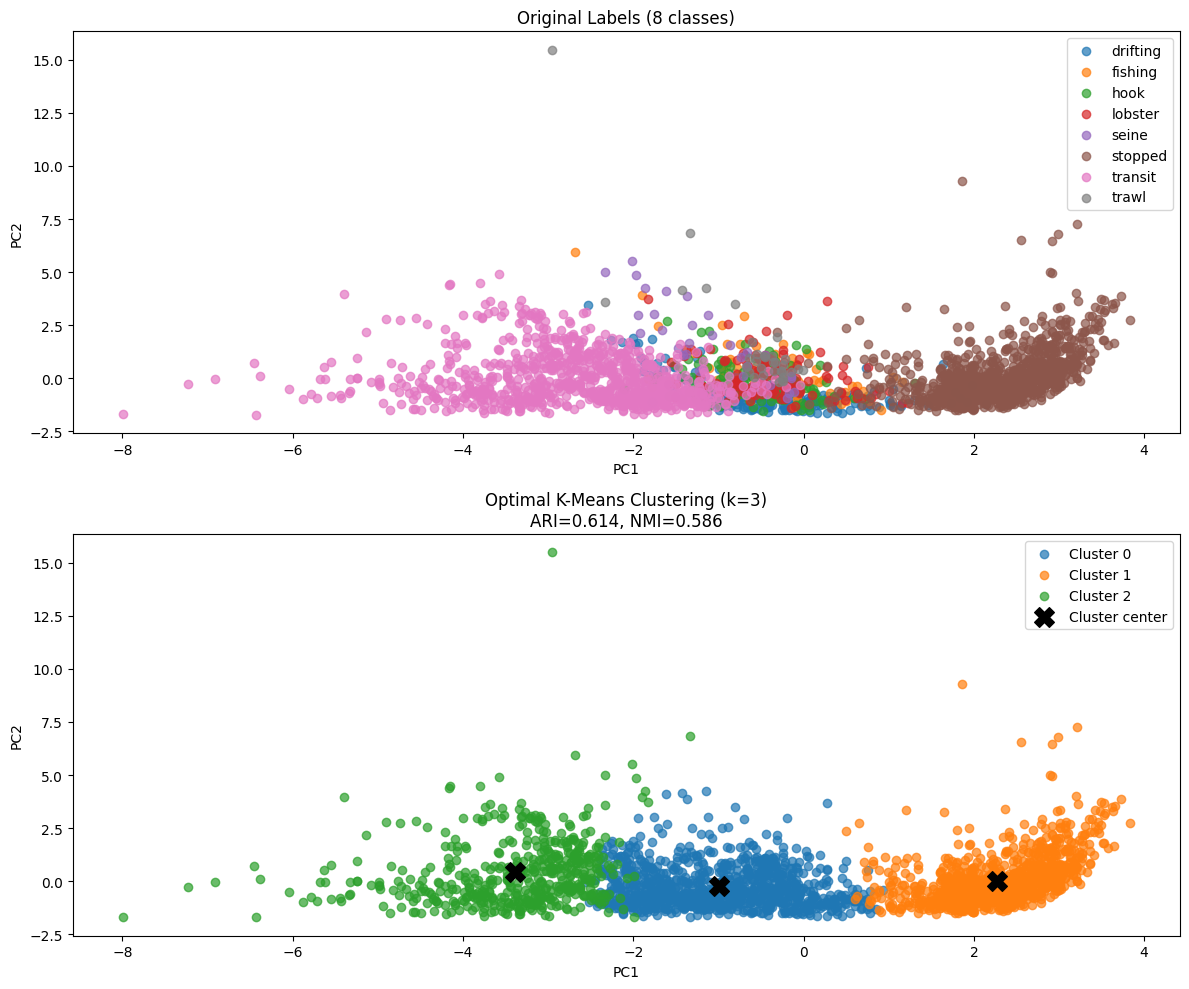

In [12]:
# Step 9: Visualize clustering with optimal number of clusters
k_optimal = optimal_k_ari  # Can choose from silhouette/ARI/NMI optimal
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_scaled)

ari_optimal = adjusted_rand_score(y_encoded, cluster_labels_optimal)
nmi_optimal = normalized_mutual_info_score(y_encoded, cluster_labels_optimal)

plt.figure(figsize=(12, 10))

# Original labels
plt.subplot(2, 1, 1)
for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.7)
plt.title(f'Original Labels ({n_classes} classes)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Optimal clusters
plt.subplot(2, 1, 2)
for i in range(k_optimal):
    mask = (cluster_labels_optimal == i)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {i}', alpha=0.7)

# Add cluster centers
cluster_centers_pca = pca.transform(kmeans_optimal.cluster_centers_)
for i in range(k_optimal):
    plt.scatter(cluster_centers_pca[i, 0], cluster_centers_pca[i, 1],
                marker='X', s=200, color='black',
                label=f'Cluster center' if i == 0 else "")

plt.title(f'Optimal K-Means Clustering (k={k_optimal})\nARI={ari_optimal:.3f}, NMI={nmi_optimal:.3f}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.tight_layout()
plt.show()

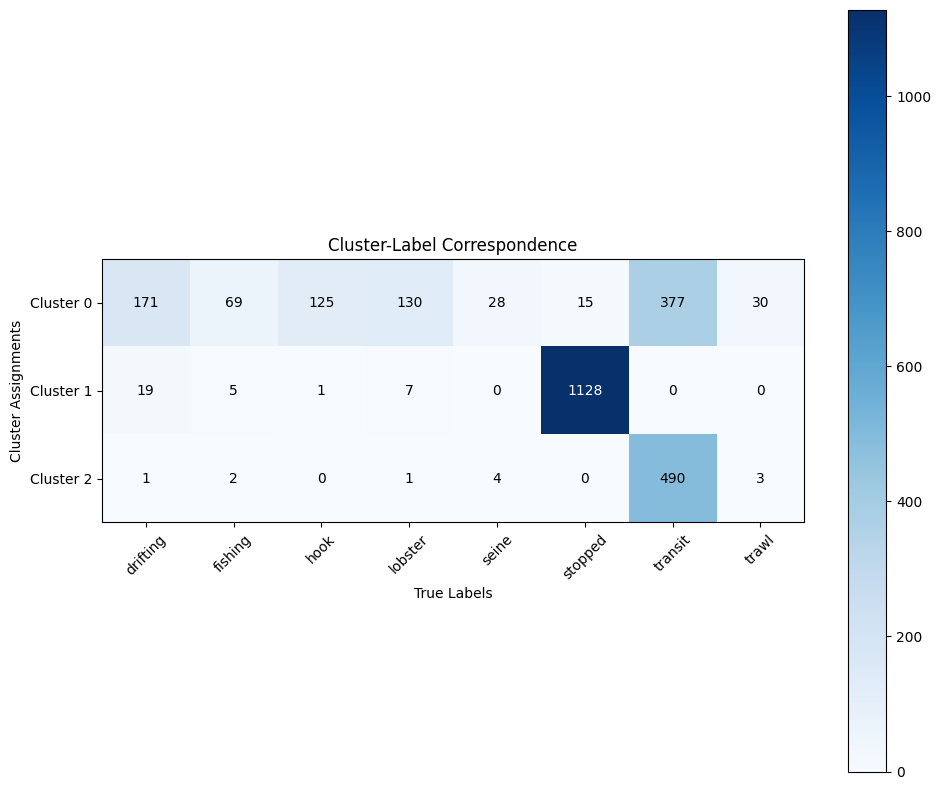

In [13]:
# Step 10: Create a confusion-matrix-like display to show the relationship
# between clusters and true labels
confusion = np.zeros((k_optimal, len(unique_labels)))
for i in range(len(y)):
    label_idx = np.where(unique_labels == y.iloc[i])[0][0]
    confusion[cluster_labels_optimal[i], label_idx] += 1

plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap='Blues')
plt.colorbar()
plt.xlabel('True Labels')
plt.ylabel('Cluster Assignments')
plt.title('Cluster-Label Correspondence')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)
plt.yticks(range(k_optimal), [f'Cluster {i}' for i in range(k_optimal)])

# Add the numbers
for i in range(k_optimal):
    for j in range(len(unique_labels)):
        plt.text(j, i, int(confusion[i, j]),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > np.max(confusion)/2 else "black")

plt.tight_layout()
plt.show()

eps=0.20, min_samples=3: clusters=14, ARI=-0.005, NMI=0.031, noise=98.08%
eps=0.30, min_samples=3: clusters=58, ARI=-0.048, NMI=0.124, noise=85.92%
eps=0.30, min_samples=5: clusters=11, ARI=-0.018, NMI=0.058, noise=95.01%
eps=0.40, min_samples=3: clusters=84, ARI=-0.038, NMI=0.237, noise=64.12%
eps=0.40, min_samples=5: clusters=34, ARI=-0.055, NMI=0.192, noise=76.48%
eps=0.40, min_samples=10: clusters=8, ARI=-0.037, NMI=0.098, noise=90.52%
eps=0.40, min_samples=15: clusters=2, ARI=-0.030, NMI=0.052, noise=94.82%
eps=0.40, min_samples=20: clusters=2, ARI=-0.015, NMI=0.023, noise=97.70%
eps=0.50, min_samples=3: clusters=66, ARI=0.231, NMI=0.359, noise=44.90%
eps=0.50, min_samples=5: clusters=23, ARI=0.126, NMI=0.310, noise=56.91%
eps=0.50, min_samples=10: clusters=12, ARI=0.013, NMI=0.220, noise=72.52%
eps=0.50, min_samples=15: clusters=5, ARI=-0.025, NMI=0.167, noise=82.81%
eps=0.50, min_samples=20: clusters=4, ARI=-0.053, NMI=0.117, noise=87.45%
eps=0.50, min_samples=25: clusters=2, AR

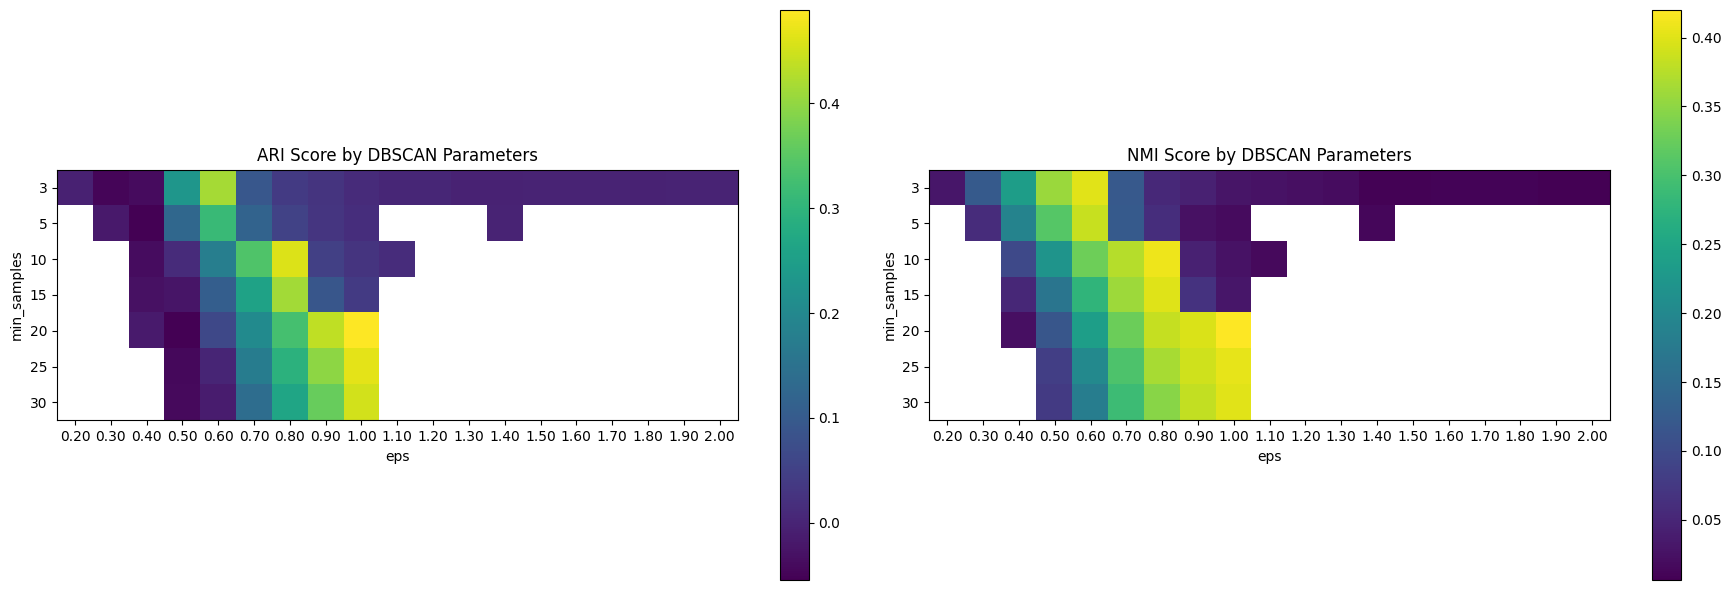

Best parameters based on ARI (0.489):
  eps = 1.00
  min_samples = 20
  clusters found = 2

Best parameters based on NMI (0.420):
  eps = 1.00
  min_samples = 20
  clusters found = 2


In [14]:
from sklearn.cluster import DBSCAN

# Define parameter ranges
eps_range = np.linspace(0.1, 2.0, 20)
min_samples_range = [3, 5, 10, 15, 20, 25, 30]

# Store results
results = []

# Grid search
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Skip configurations that find only noise or a single cluster
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue

        # Calculate metrics
        try:
            silhouette = silhouette_score(X_scaled, labels)
        except:
            silhouette = -1

        ari = adjusted_rand_score(y_encoded, labels)
        nmi = normalized_mutual_info_score(y_encoded, labels)
        noise = np.sum(labels == -1) / len(labels)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'ari': ari,
            'nmi': nmi,
            'noise_ratio': noise
        })

        print(f"eps={eps:.2f}, min_samples={min_samples}: clusters={n_clusters}, ARI={ari:.3f}, NMI={nmi:.3f}, noise={noise:.2%}")

# Create a heatmap of ARI scores
if results:
    # Convert to DataFrame for easier manipulation
    import pandas as pd
    df_results = pd.DataFrame(results)

    # Create pivot tables for heatmaps
    ari_pivot = df_results.pivot_table(index='min_samples', columns='eps', values='ari', aggfunc='max')
    nmi_pivot = df_results.pivot_table(index='min_samples', columns='eps', values='nmi', aggfunc='max')

    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    cmap = plt.cm.viridis

    # ARI heatmap
    im0 = axes[0].imshow(ari_pivot, cmap=cmap)
    axes[0].set_title('ARI Score by DBSCAN Parameters')
    axes[0].set_xlabel('eps')
    axes[0].set_ylabel('min_samples')
    axes[0].set_xticks(np.arange(len(ari_pivot.columns)))
    axes[0].set_yticks(np.arange(len(ari_pivot.index)))
    axes[0].set_xticklabels([f"{x:.2f}" for x in ari_pivot.columns])
    axes[0].set_yticklabels(ari_pivot.index)
    plt.colorbar(im0, ax=axes[0])

    # NMI heatmap
    im1 = axes[1].imshow(nmi_pivot, cmap=cmap)
    axes[1].set_title('NMI Score by DBSCAN Parameters')
    axes[1].set_xlabel('eps')
    axes[1].set_ylabel('min_samples')
    axes[1].set_xticks(np.arange(len(nmi_pivot.columns)))
    axes[1].set_yticks(np.arange(len(nmi_pivot.index)))
    axes[1].set_xticklabels([f"{x:.2f}" for x in nmi_pivot.columns])
    axes[1].set_yticklabels(nmi_pivot.index)
    plt.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Find best parameters
    best_ari_idx = df_results['ari'].idxmax()
    best_nmi_idx = df_results['nmi'].idxmax()

    print(f"Best parameters based on ARI ({df_results.loc[best_ari_idx, 'ari']:.3f}):")
    print(f"  eps = {df_results.loc[best_ari_idx, 'eps']:.2f}")
    print(f"  min_samples = {df_results.loc[best_ari_idx, 'min_samples']}")
    print(f"  clusters found = {df_results.loc[best_ari_idx, 'n_clusters']}")

    print(f"\nBest parameters based on NMI ({df_results.loc[best_nmi_idx, 'nmi']:.3f}):")
    print(f"  eps = {df_results.loc[best_nmi_idx, 'eps']:.2f}")
    print(f"  min_samples = {df_results.loc[best_nmi_idx, 'min_samples']}")
    print(f"  clusters found = {df_results.loc[best_nmi_idx, 'n_clusters']}")

n_comp=2, cov_type=full: ARI=0.599, NMI=0.598, BIC=7262
n_comp=2, cov_type=tied: ARI=0.545, NMI=0.552, BIC=51885
n_comp=2, cov_type=diag: ARI=0.595, NMI=0.599, BIC=21090
n_comp=2, cov_type=spherical: ARI=0.448, NMI=0.450, BIC=68699
n_comp=3, cov_type=full: ARI=0.802, NMI=0.686, BIC=-6358
n_comp=3, cov_type=tied: ARI=0.434, NMI=0.508, BIC=49977
n_comp=3, cov_type=diag: ARI=0.817, NMI=0.703, BIC=6518
n_comp=3, cov_type=spherical: ARI=0.455, NMI=0.435, BIC=62646
n_comp=4, cov_type=full: ARI=0.654, NMI=0.643, BIC=-24242
n_comp=4, cov_type=tied: ARI=0.550, NMI=0.540, BIC=47283
n_comp=4, cov_type=diag: ARI=0.687, NMI=0.642, BIC=-8233
n_comp=4, cov_type=spherical: ARI=0.497, NMI=0.519, BIC=59220
n_comp=5, cov_type=full: ARI=0.651, NMI=0.618, BIC=-26492
n_comp=5, cov_type=tied: ARI=0.526, NMI=0.522, BIC=45470
n_comp=5, cov_type=diag: ARI=0.575, NMI=0.609, BIC=-15045
n_comp=5, cov_type=spherical: ARI=0.464, NMI=0.491, BIC=56947
n_comp=6, cov_type=full: ARI=0.497, NMI=0.573, BIC=-34108
n_comp=6,

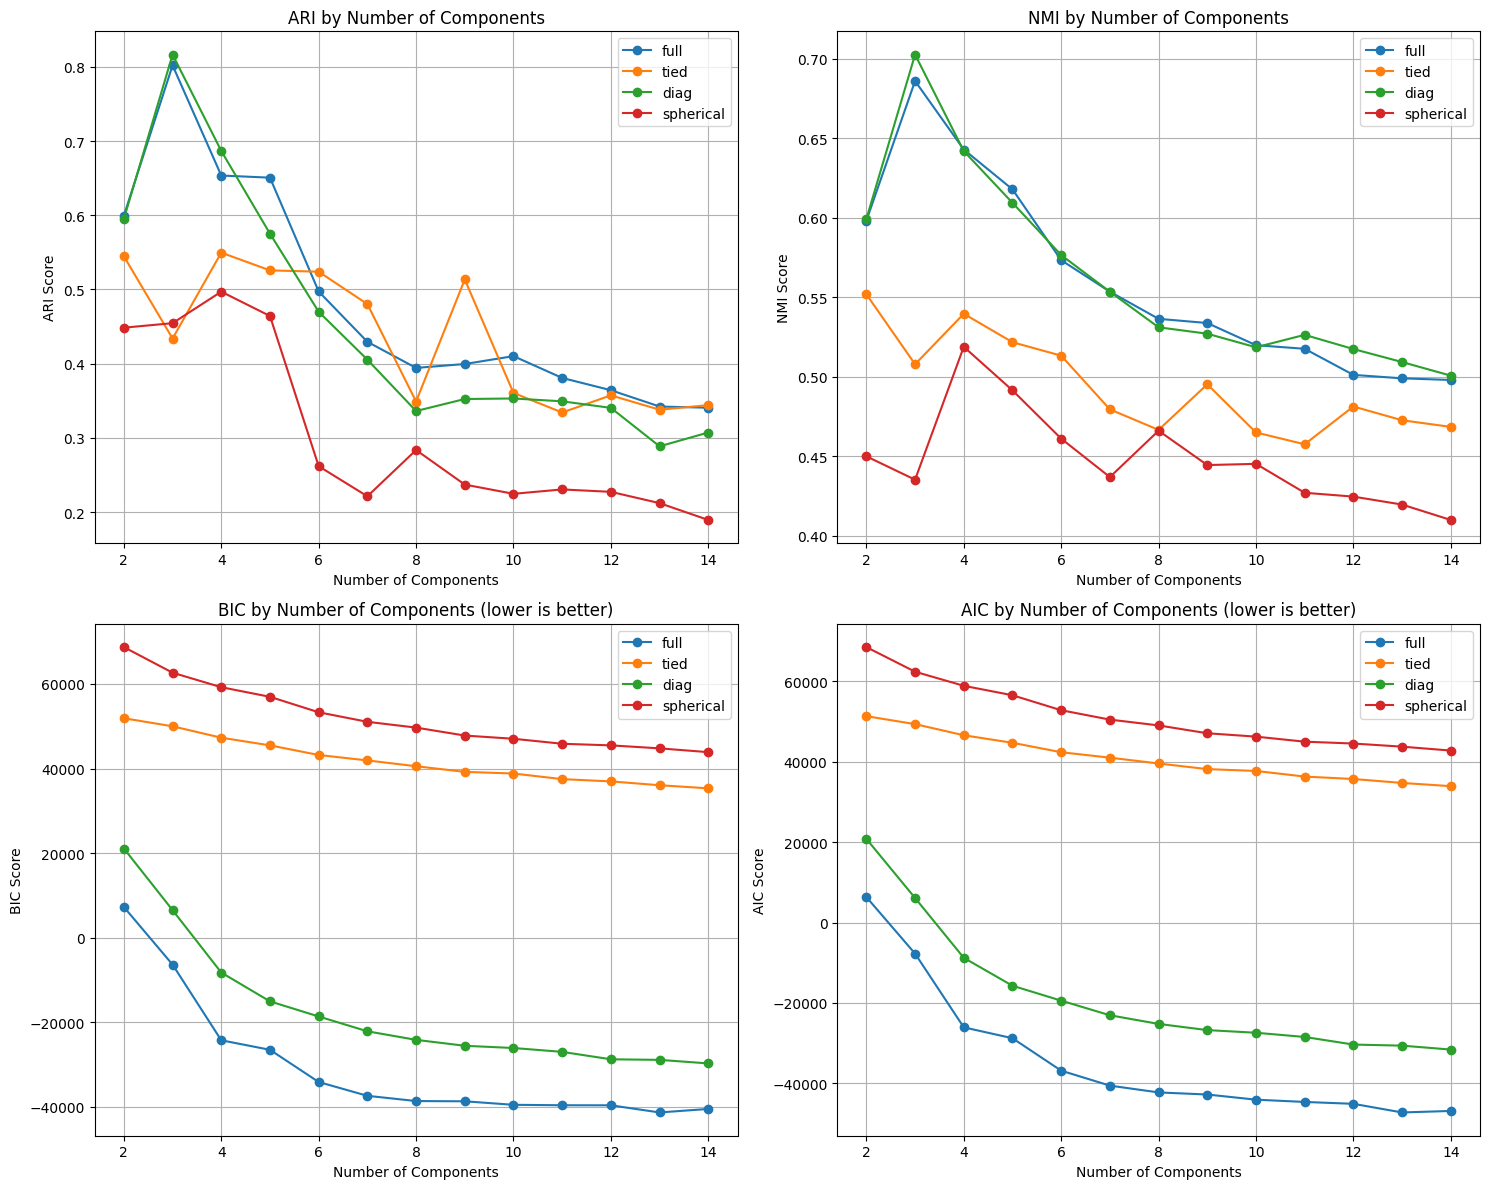

Best GMM parameters based on ARI (0.817):
  n_components = 3
  covariance_type = diag

Best GMM parameters based on BIC (-41304):
  n_components = 13
  covariance_type = full


In [15]:
from sklearn.mixture import GaussianMixture

# Parameters to tune
n_components_range = range(2, 15)
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store results
gmm_results = []

# Grid search
for n_comp in n_components_range:
    for cov_type in covariance_types:
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cov_type,
            random_state=42,
            n_init=5
        )

        labels = gmm.fit_predict(X_scaled)

        # Calculate metrics
        ari = adjusted_rand_score(y_encoded, labels)
        nmi = normalized_mutual_info_score(y_encoded, labels)
        bic = gmm.bic(X_scaled)
        aic = gmm.aic(X_scaled)

        try:
            silhouette = silhouette_score(X_scaled, labels)
        except:
            silhouette = -1

        gmm_results.append({
            'n_components': n_comp,
            'covariance_type': cov_type,
            'ari': ari,
            'nmi': nmi,
            'bic': bic,
            'aic': aic,
            'silhouette': silhouette
        })

        print(f"n_comp={n_comp}, cov_type={cov_type}: ARI={ari:.3f}, NMI={nmi:.3f}, BIC={bic:.0f}")

# Convert to DataFrame
if gmm_results:
    import pandas as pd
    df_gmm = pd.DataFrame(gmm_results)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot ARI and NMI by number of components for each covariance type
    for cov_type in covariance_types:
        mask = df_gmm['covariance_type'] == cov_type
        axes[0, 0].plot(df_gmm.loc[mask, 'n_components'], df_gmm.loc[mask, 'ari'],
                       marker='o', label=cov_type)
        axes[0, 1].plot(df_gmm.loc[mask, 'n_components'], df_gmm.loc[mask, 'nmi'],
                       marker='o', label=cov_type)

    axes[0, 0].set_title('ARI by Number of Components')
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('ARI Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_title('NMI by Number of Components')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('NMI Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot BIC and AIC by number of components for each covariance type
    for cov_type in covariance_types:
        mask = df_gmm['covariance_type'] == cov_type
        axes[1, 0].plot(df_gmm.loc[mask, 'n_components'], df_gmm.loc[mask, 'bic'],
                       marker='o', label=cov_type)
        axes[1, 1].plot(df_gmm.loc[mask, 'n_components'], df_gmm.loc[mask, 'aic'],
                       marker='o', label=cov_type)

    axes[1, 0].set_title('BIC by Number of Components (lower is better)')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('BIC Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].set_title('AIC by Number of Components (lower is better)')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('AIC Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Find best parameters
    best_ari_idx = df_gmm['ari'].idxmax()
    best_bic_idx = df_gmm['bic'].idxmin()  # BIC - lower is better

    print(f"Best GMM parameters based on ARI ({df_gmm.loc[best_ari_idx, 'ari']:.3f}):")
    print(f"  n_components = {df_gmm.loc[best_ari_idx, 'n_components']}")
    print(f"  covariance_type = {df_gmm.loc[best_ari_idx, 'covariance_type']}")

    print(f"\nBest GMM parameters based on BIC ({df_gmm.loc[best_bic_idx, 'bic']:.0f}):")
    print(f"  n_components = {df_gmm.loc[best_bic_idx, 'n_components']}")
    print(f"  covariance_type = {df_gmm.loc[best_bic_idx, 'covariance_type']}")

n_clust=2, affinity=nearest_neighbors, n_neighbors=5: ARI=0.584, NMI=0.571
n_clust=2, affinity=nearest_neighbors, n_neighbors=10: ARI=0.589, NMI=0.573
n_clust=2, affinity=nearest_neighbors, n_neighbors=15: ARI=0.591, NMI=0.574
n_clust=2, affinity=nearest_neighbors, n_neighbors=20: ARI=0.591, NMI=0.574
n_clust=2, affinity=nearest_neighbors, n_neighbors=30: ARI=0.592, NMI=0.575
n_clust=2, affinity=rbf: ARI=0.001, NMI=0.002
n_clust=3, affinity=nearest_neighbors, n_neighbors=5: ARI=0.434, NMI=0.501
n_clust=3, affinity=nearest_neighbors, n_neighbors=10: ARI=0.476, NMI=0.515
n_clust=3, affinity=nearest_neighbors, n_neighbors=15: ARI=0.466, NMI=0.511
n_clust=3, affinity=nearest_neighbors, n_neighbors=20: ARI=0.459, NMI=0.510
n_clust=3, affinity=nearest_neighbors, n_neighbors=30: ARI=0.432, NMI=0.505
n_clust=3, affinity=rbf: ARI=-0.000, NMI=0.004
n_clust=4, affinity=nearest_neighbors, n_neighbors=5: ARI=0.411, NMI=0.529
n_clust=4, affinity=nearest_neighbors, n_neighbors=10: ARI=0.465, NMI=0.53

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


n_clust=6, affinity=rbf: ARI=0.002, NMI=0.005
n_clust=7, affinity=nearest_neighbors, n_neighbors=5: ARI=0.402, NMI=0.493
n_clust=7, affinity=nearest_neighbors, n_neighbors=10: ARI=0.267, NMI=0.466
n_clust=7, affinity=nearest_neighbors, n_neighbors=15: ARI=0.282, NMI=0.464
n_clust=7, affinity=nearest_neighbors, n_neighbors=20: ARI=0.317, NMI=0.435
n_clust=7, affinity=nearest_neighbors, n_neighbors=30: ARI=0.322, NMI=0.440
n_clust=7, affinity=rbf: ARI=0.001, NMI=0.008
n_clust=8, affinity=nearest_neighbors, n_neighbors=5: ARI=0.258, NMI=0.455
n_clust=8, affinity=nearest_neighbors, n_neighbors=10: ARI=0.293, NMI=0.464
n_clust=8, affinity=nearest_neighbors, n_neighbors=15: ARI=0.194, NMI=0.446
n_clust=8, affinity=nearest_neighbors, n_neighbors=20: ARI=0.226, NMI=0.418
n_clust=8, affinity=nearest_neighbors, n_neighbors=30: ARI=0.230, NMI=0.422
n_clust=8, affinity=rbf: ARI=0.007, NMI=0.011
n_clust=9, affinity=nearest_neighbors, n_neighbors=5: ARI=0.186, NMI=0.441
n_clust=9, affinity=nearest_n

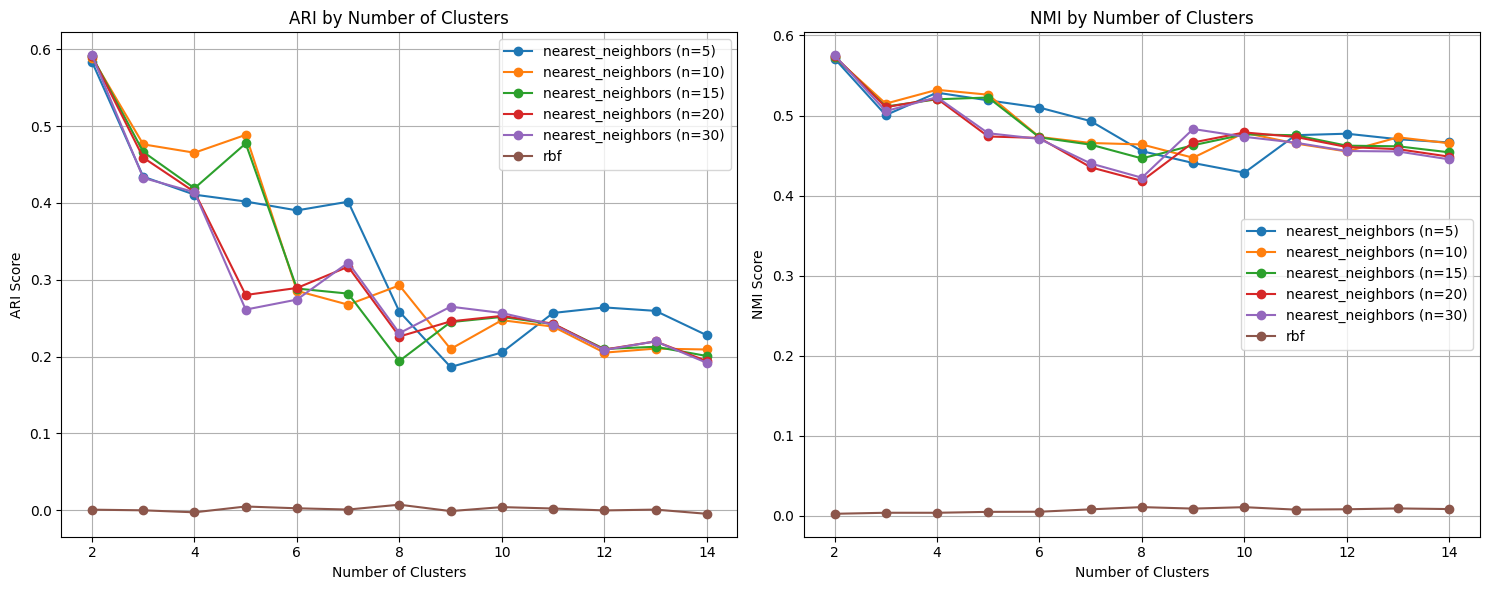

Best Spectral Clustering parameters based on ARI (0.592):
  n_clusters = 2
  affinity = nearest_neighbors
  n_neighbors = 30.0

Best Spectral Clustering parameters based on NMI (0.575):
  n_clusters = 2
  affinity = nearest_neighbors
  n_neighbors = 30.0


In [16]:
from sklearn.cluster import SpectralClustering

# Parameters to tune
n_clusters_range = range(2, 15)
affinity_types = ['nearest_neighbors', 'rbf']
n_neighbors_range = [5, 10, 15, 20, 30]

# Store results
spectral_results = []

# Grid search - start with affinities
for n_clust in n_clusters_range:
    for affinity in affinity_types:
        if affinity == 'nearest_neighbors':
            for n_neighbors in n_neighbors_range:
                spectral = SpectralClustering(
                    n_clusters=n_clust,
                    affinity=affinity,
                    n_neighbors=n_neighbors,
                    random_state=42
                )

                labels = spectral.fit_predict(X_scaled)

                # Calculate metrics
                ari = adjusted_rand_score(y_encoded, labels)
                nmi = normalized_mutual_info_score(y_encoded, labels)

                try:
                    silhouette = silhouette_score(X_scaled, labels)
                except:
                    silhouette = -1

                spectral_results.append({
                    'n_clusters': n_clust,
                    'affinity': affinity,
                    'n_neighbors': n_neighbors,
                    'ari': ari,
                    'nmi': nmi,
                    'silhouette': silhouette
                })

                print(f"n_clust={n_clust}, affinity={affinity}, n_neighbors={n_neighbors}: ARI={ari:.3f}, NMI={nmi:.3f}")
        else:
            spectral = SpectralClustering(
                n_clusters=n_clust,
                affinity=affinity,
                random_state=42
            )

            labels = spectral.fit_predict(X_scaled)

            # Calculate metrics
            ari = adjusted_rand_score(y_encoded, labels)
            nmi = normalized_mutual_info_score(y_encoded, labels)

            try:
                silhouette = silhouette_score(X_scaled, labels)
            except:
                silhouette = -1

            spectral_results.append({
                'n_clusters': n_clust,
                'affinity': affinity,
                'n_neighbors': None,
                'ari': ari,
                'nmi': nmi,
                'silhouette': silhouette
            })

            print(f"n_clust={n_clust}, affinity={affinity}: ARI={ari:.3f}, NMI={nmi:.3f}")

# Convert to DataFrame
if spectral_results:
    import pandas as pd
    df_spectral = pd.DataFrame(spectral_results)

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot ARI by number of clusters for different affinities
    for affinity in affinity_types:
        if affinity == 'nearest_neighbors':
            for n_neighbors in n_neighbors_range:
                mask = (df_spectral['affinity'] == affinity) & (df_spectral['n_neighbors'] == n_neighbors)
                axes[0].plot(df_spectral.loc[mask, 'n_clusters'], df_spectral.loc[mask, 'ari'],
                           marker='o', label=f"{affinity} (n={n_neighbors})")
        else:
            mask = df_spectral['affinity'] == affinity
            axes[0].plot(df_spectral.loc[mask, 'n_clusters'], df_spectral.loc[mask, 'ari'],
                       marker='o', label=affinity)

    axes[0].set_title('ARI by Number of Clusters')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('ARI Score')
    axes[0].legend()
    axes[0].grid(True)

    # Plot NMI by number of clusters for different affinities
    for affinity in affinity_types:
        if affinity == 'nearest_neighbors':
            for n_neighbors in n_neighbors_range:
                mask = (df_spectral['affinity'] == affinity) & (df_spectral['n_neighbors'] == n_neighbors)
                axes[1].plot(df_spectral.loc[mask, 'n_clusters'], df_spectral.loc[mask, 'nmi'],
                           marker='o', label=f"{affinity} (n={n_neighbors})")
        else:
            mask = df_spectral['affinity'] == affinity
            axes[1].plot(df_spectral.loc[mask, 'n_clusters'], df_spectral.loc[mask, 'nmi'],
                       marker='o', label=affinity)

    axes[1].set_title('NMI by Number of Clusters')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('NMI Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Find best parameters
    best_ari_idx = df_spectral['ari'].idxmax()
    best_nmi_idx = df_spectral['nmi'].idxmax()

    print(f"Best Spectral Clustering parameters based on ARI ({df_spectral.loc[best_ari_idx, 'ari']:.3f}):")
    print(f"  n_clusters = {df_spectral.loc[best_ari_idx, 'n_clusters']}")
    print(f"  affinity = {df_spectral.loc[best_ari_idx, 'affinity']}")
    if df_spectral.loc[best_ari_idx, 'affinity'] == 'nearest_neighbors':
        print(f"  n_neighbors = {df_spectral.loc[best_ari_idx, 'n_neighbors']}")

    print(f"\nBest Spectral Clustering parameters based on NMI ({df_spectral.loc[best_nmi_idx, 'nmi']:.3f}):")
    print(f"  n_clusters = {df_spectral.loc[best_nmi_idx, 'n_clusters']}")
    print(f"  affinity = {df_spectral.loc[best_nmi_idx, 'affinity']}")
    if df_spectral.loc[best_nmi_idx, 'affinity'] == 'nearest_neighbors':
        print(f"  n_neighbors = {df_spectral.loc[best_nmi_idx, 'n_neighbors']}")

n_clust=2, linkage=ward: ARI=0.591, NMI=0.587
n_clust=2, linkage=complete: ARI=-0.006, NMI=0.009
n_clust=2, linkage=average: ARI=0.000, NMI=0.002
n_clust=2, linkage=single: ARI=0.001, NMI=0.002
n_clust=3, linkage=ward: ARI=0.606, NMI=0.569
n_clust=3, linkage=complete: ARI=-0.005, NMI=0.011
n_clust=3, linkage=average: ARI=-0.003, NMI=0.007
n_clust=3, linkage=single: ARI=0.000, NMI=0.003
n_clust=4, linkage=ward: ARI=0.596, NMI=0.564
n_clust=4, linkage=complete: ARI=0.039, NMI=0.162
n_clust=4, linkage=average: ARI=-0.003, NMI=0.008
n_clust=4, linkage=single: ARI=-0.001, NMI=0.004
n_clust=5, linkage=ward: ARI=0.561, NMI=0.542
n_clust=5, linkage=complete: ARI=0.038, NMI=0.162
n_clust=5, linkage=average: ARI=-0.003, NMI=0.009
n_clust=5, linkage=single: ARI=-0.000, NMI=0.006
n_clust=6, linkage=ward: ARI=0.470, NMI=0.515
n_clust=6, linkage=complete: ARI=0.038, NMI=0.163
n_clust=6, linkage=average: ARI=-0.003, NMI=0.009
n_clust=6, linkage=single: ARI=0.001, NMI=0.008
n_clust=7, linkage=ward: AR

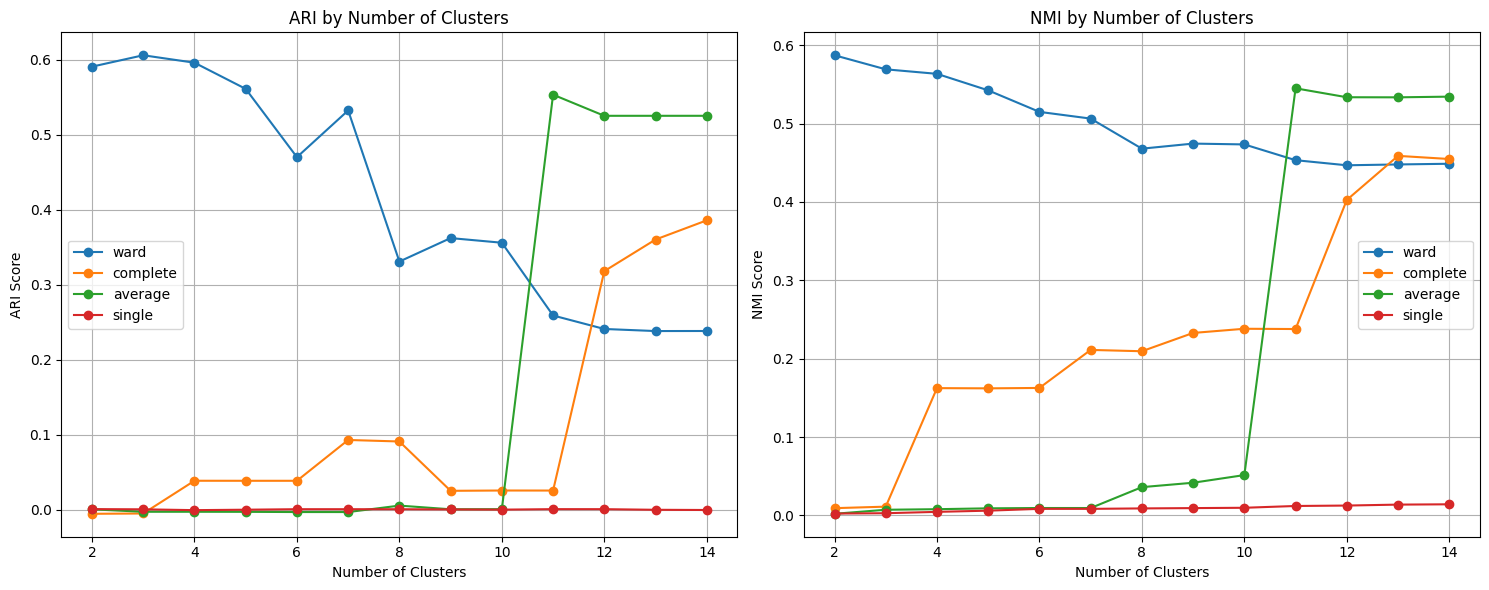

Best Agglomerative Clustering parameters based on ARI (0.606):
  n_clusters = 3
  linkage = ward

Best Agglomerative Clustering parameters based on NMI (0.587):
  n_clusters = 2
  linkage = ward


In [17]:
from sklearn.cluster import AgglomerativeClustering

# Parameters to tune
n_clusters_range = range(2, 15)
linkage_methods = ['ward', 'complete', 'average', 'single']

# Store results
agg_results = []

# Grid search
for n_clust in n_clusters_range:
    for linkage in linkage_methods:
        if linkage == 'ward' and n_clust == 1:
            continue  # ward linkage requires n_clusters >= 2

        agg = AgglomerativeClustering(
            n_clusters=n_clust,
            linkage=linkage
        )

        labels = agg.fit_predict(X_scaled)

        # Calculate metrics
        ari = adjusted_rand_score(y_encoded, labels)
        nmi = normalized_mutual_info_score(y_encoded, labels)

        try:
            silhouette = silhouette_score(X_scaled, labels)
        except:
            silhouette = -1

        agg_results.append({
            'n_clusters': n_clust,
            'linkage': linkage,
            'ari': ari,
            'nmi': nmi,
            'silhouette': silhouette
        })

        print(f"n_clust={n_clust}, linkage={linkage}: ARI={ari:.3f}, NMI={nmi:.3f}")

# Convert to DataFrame
if agg_results:
    import pandas as pd
    df_agg = pd.DataFrame(agg_results)

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot ARI by number of clusters for different linkage methods
    for linkage in linkage_methods:
        mask = df_agg['linkage'] == linkage
        axes[0].plot(df_agg.loc[mask, 'n_clusters'], df_agg.loc[mask, 'ari'],
                   marker='o', label=linkage)

    axes[0].set_title('ARI by Number of Clusters')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('ARI Score')
    axes[0].legend()
    axes[0].grid(True)

    # Plot NMI by number of clusters for different linkage methods
    for linkage in linkage_methods:
        mask = df_agg['linkage'] == linkage
        axes[1].plot(df_agg.loc[mask, 'n_clusters'], df_agg.loc[mask, 'nmi'],
                   marker='o', label=linkage)

    axes[1].set_title('NMI by Number of Clusters')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('NMI Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Find best parameters
    best_ari_idx = df_agg['ari'].idxmax()
    best_nmi_idx = df_agg['nmi'].idxmax()

    print(f"Best Agglomerative Clustering parameters based on ARI ({df_agg.loc[best_ari_idx, 'ari']:.3f}):")
    print(f"  n_clusters = {df_agg.loc[best_ari_idx, 'n_clusters']}")
    print(f"  linkage = {df_agg.loc[best_ari_idx, 'linkage']}")

    print(f"\nBest Agglomerative Clustering parameters based on NMI ({df_agg.loc[best_nmi_idx, 'nmi']:.3f}):")
    print(f"  n_clusters = {df_agg.loc[best_nmi_idx, 'n_clusters']}")
    print(f"  linkage = {df_agg.loc[best_nmi_idx, 'linkage']}")

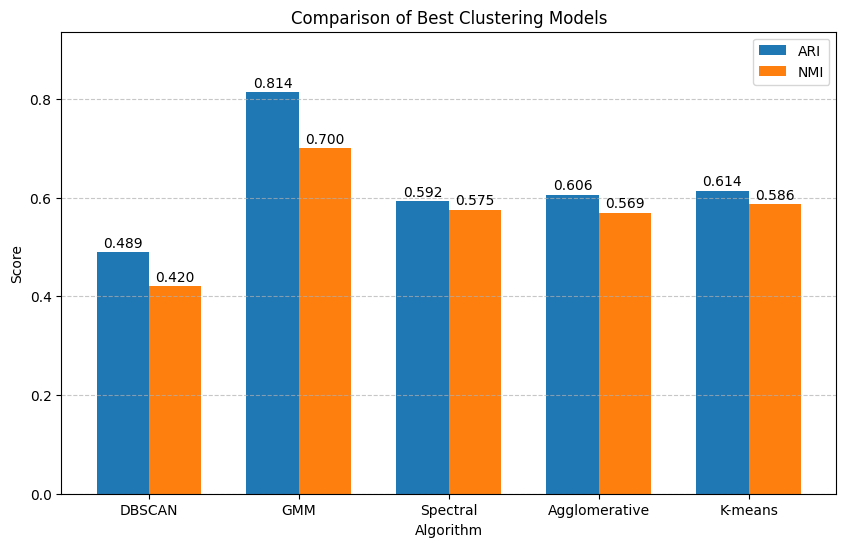

Best clustering models ranked by ARI score:
1. GMM (ARI: 0.814, NMI: 0.700)
   Parameters: n_components=3, covariance_type=diag
2. K-means (ARI: 0.614, NMI: 0.586)
   Parameters: n_clusters=8
3. Agglomerative (ARI: 0.606, NMI: 0.569)
   Parameters: n_clusters=3, linkage=ward
4. Spectral (ARI: 0.592, NMI: 0.575)
   Parameters: n_clusters=2, affinity=nearest_neighbors, n_neighbors=30
5. DBSCAN (ARI: 0.489, NMI: 0.420)
   Parameters: eps=1.00, min_samples=20


In [18]:
# After running all hyperparameter searches, compare the best models
best_models = []

# 1. Best DBSCAN
if 'df_results' in locals():
    best_dbscan_idx = df_results['ari'].idxmax()
    best_eps = df_results.loc[best_dbscan_idx, 'eps']
    best_min_samples = df_results.loc[best_dbscan_idx, 'min_samples']

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    if len(set(dbscan_labels)) > 1:  # Ensure more than just noise was found
        ari_dbscan = adjusted_rand_score(y_encoded, dbscan_labels)
        nmi_dbscan = normalized_mutual_info_score(y_encoded, dbscan_labels)

        best_models.append({
            'name': 'DBSCAN',
            'ari': ari_dbscan,
            'nmi': nmi_dbscan,
            'params': f"eps={best_eps:.2f}, min_samples={best_min_samples}"
        })

# 2. Best GMM
if 'df_gmm' in locals():
    best_gmm_idx = df_gmm['ari'].idxmax()
    best_n_components = df_gmm.loc[best_gmm_idx, 'n_components']
    best_cov_type = df_gmm.loc[best_gmm_idx, 'covariance_type']

    gmm = GaussianMixture(n_components=best_n_components, covariance_type=best_cov_type, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)

    ari_gmm = adjusted_rand_score(y_encoded, gmm_labels)
    nmi_gmm = normalized_mutual_info_score(y_encoded, gmm_labels)

    best_models.append({
        'name': 'GMM',
        'ari': ari_gmm,
        'nmi': nmi_gmm,
        'params': f"n_components={best_n_components}, covariance_type={best_cov_type}"
    })

# 3. Best Spectral
if 'df_spectral' in locals():
    best_spectral_idx = df_spectral['ari'].idxmax()
    best_n_clusters = int(df_spectral.loc[best_spectral_idx, 'n_clusters'])  # Convert to int
    best_affinity = df_spectral.loc[best_spectral_idx, 'affinity']
    best_n_neighbors = df_spectral.loc[best_spectral_idx, 'n_neighbors']

    if best_affinity == 'nearest_neighbors':
        spectral = SpectralClustering(
            n_clusters=best_n_clusters,
            affinity=best_affinity,
            n_neighbors=int(best_n_neighbors),  # Convert to int
            random_state=42
        )
    else:
        spectral = SpectralClustering(
            n_clusters=best_n_clusters,
            affinity=best_affinity,
            random_state=42
        )

    spectral_labels = spectral.fit_predict(X_scaled)

    ari_spectral = adjusted_rand_score(y_encoded, spectral_labels)
    nmi_spectral = normalized_mutual_info_score(y_encoded, spectral_labels)

    n_neighbors_str = f", n_neighbors={int(best_n_neighbors)}" if best_affinity == 'nearest_neighbors' else ""

    best_models.append({
        'name': 'Spectral',
        'ari': ari_spectral,
        'nmi': nmi_spectral,
        'params': f"n_clusters={best_n_clusters}, affinity={best_affinity}{n_neighbors_str}"
    })

# 4. Best Agglomerative
if 'df_agg' in locals():
    best_agg_idx = df_agg['ari'].idxmax()
    best_n_clusters = df_agg.loc[best_agg_idx, 'n_clusters']
    best_linkage = df_agg.loc[best_agg_idx, 'linkage']

    agg = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage)
    agg_labels = agg.fit_predict(X_scaled)

    ari_agg = adjusted_rand_score(y_encoded, agg_labels)
    nmi_agg = normalized_mutual_info_score(y_encoded, agg_labels)

    best_models.append({
        'name': 'Agglomerative',
        'ari': ari_agg,
        'nmi': nmi_agg,
        'params': f"n_clusters={best_n_clusters}, linkage={best_linkage}"
    })

# 5. K-means (for reference)
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

ari_kmeans = adjusted_rand_score(y_encoded, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y_encoded, kmeans_labels)

best_models.append({
    'name': 'K-means',
    'ari': ari_kmeans,
    'nmi': nmi_kmeans,
    'params': f"n_clusters={len(np.unique(y))}"
})

# Plot final comparison
if best_models:
    import pandas as pd
    df_best = pd.DataFrame(best_models)

    plt.figure(figsize=(10, 6))

    x = np.arange(len(df_best))
    width = 0.35

    plt.bar(x - width/2, df_best['ari'], width, label='ARI')
    plt.bar(x + width/2, df_best['nmi'], width, label='NMI')

    plt.xlabel('Algorithm')
    plt.ylabel('Score')
    plt.title('Comparison of Best Clustering Models')
    plt.xticks(x, df_best['name'])
    plt.legend()

    # Add value labels on bars
    for i, v in enumerate(df_best['ari']):
        plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')

    for i, v in enumerate(df_best['nmi']):
        plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

    plt.ylim(0, max(df_best['ari'].max(), df_best['nmi'].max()) * 1.15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Print best model details
    df_best = df_best.sort_values('ari', ascending=False).reset_index(drop=True)
    print("Best clustering models ranked by ARI score:")
    for i, row in df_best.iterrows():
        print(f"{i+1}. {row['name']} (ARI: {row['ari']:.3f}, NMI: {row['nmi']:.3f})")
        print(f"   Parameters: {row['params']}")

GMM Performance Metrics:
ARI: 0.817
NMI: 0.703
Parameters: n_components=3, covariance_type=diag


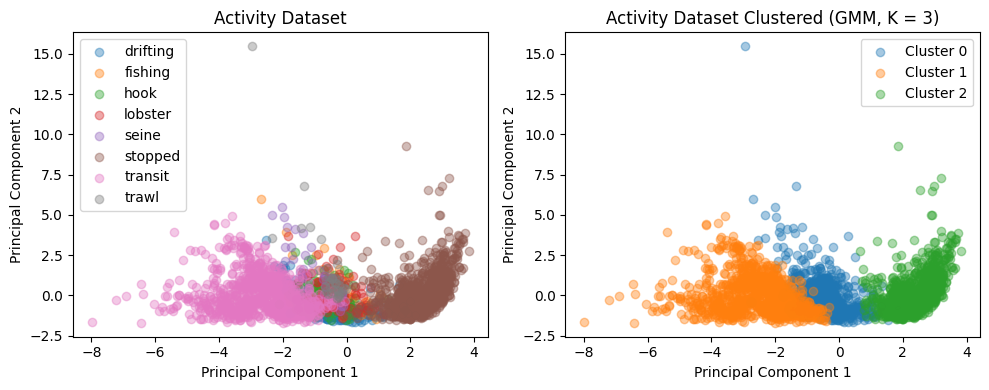

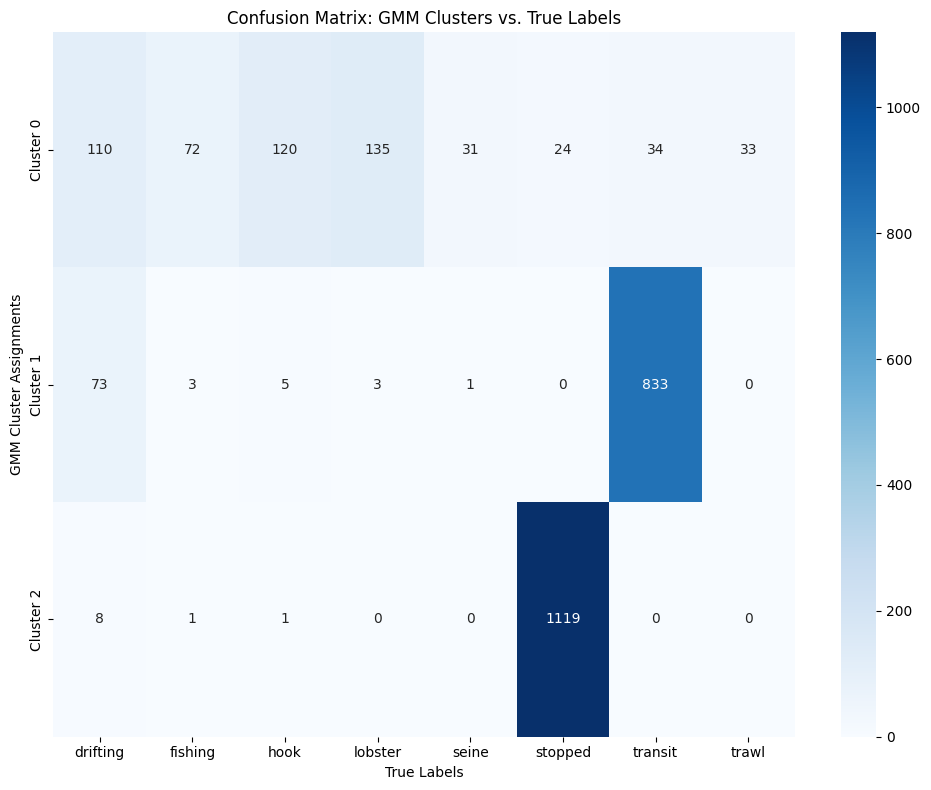


Mapping from true labels to GMM clusters:
True label 'drifting' → Cluster 0 (matches 57.6% of the label's points)
True label 'fishing' → Cluster 0 (matches 94.7% of the label's points)
True label 'hook' → Cluster 0 (matches 95.2% of the label's points)
True label 'lobster' → Cluster 0 (matches 97.8% of the label's points)
True label 'seine' → Cluster 0 (matches 96.9% of the label's points)
True label 'stopped' → Cluster 2 (matches 97.9% of the label's points)
True label 'transit' → Cluster 1 (matches 96.1% of the label's points)
True label 'trawl' → Cluster 0 (matches 100.0% of the label's points)

Most common misclassifications:
True label 'drifting' incorrectly assigned to Cluster 1 (38.2%)


In [29]:
import seaborn as sns

# Get the best GMM parameters from your previous results
# Replace these with your actual best parameters
best_n_components = 3
best_cov_type = 'diag'

# Fit GMM with the best parameters
gmm = GaussianMixture(
    n_components=best_n_components,
    covariance_type=best_cov_type,
    random_state=42,
    n_init=10
)
gmm_labels = gmm.fit_predict(X_scaled)

# Calculate metrics
ari_gmm = adjusted_rand_score(y_encoded, gmm_labels)
nmi_gmm = normalized_mutual_info_score(y_encoded, gmm_labels)

print(f"GMM Performance Metrics:")
print(f"ARI: {ari_gmm:.3f}")
print(f"NMI: {nmi_gmm:.3f}")
print(f"Parameters: n_components={best_n_components}, covariance_type={best_cov_type}")

# Create PCA visualization
plt.figure(figsize=(10, 4))

# Original labels
plt.subplot(1, 2, 1)
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.4)
plt.title('Activity Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# GMM clusters
plt.subplot(1, 2, 2)
for i in range(best_n_components):
    mask = (gmm_labels == i)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {i}', alpha=0.4)
plt.title(f'Activity Dataset Clustered (GMM, K = 3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()

# Create confusion matrix
confusion = np.zeros((best_n_components, len(unique_labels)))
for i in range(len(y)):
    true_label_idx = np.where(unique_labels == y.iloc[i])[0][0]
    confusion[gmm_labels[i], true_label_idx] += 1

# Create a DataFrame for better visualization
conf_df = pd.DataFrame(confusion,
                       index=[f'Cluster {i}' for i in range(best_n_components)],
                       columns=unique_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix: GMM Clusters vs. True Labels')
plt.xlabel('True Labels')
plt.ylabel('GMM Cluster Assignments')
plt.tight_layout()
plt.show()

# Calculate which GMM cluster best represents each true label
best_matches = {}
for j, true_label in enumerate(unique_labels):
    best_cluster = np.argmax(confusion[:, j])
    match_quality = confusion[best_cluster, j] / np.sum(confusion[:, j])
    best_matches[true_label] = (best_cluster, match_quality)

print("\nMapping from true labels to GMM clusters:")
for label, (cluster, quality) in best_matches.items():
    print(f"True label '{label}' → Cluster {cluster} (matches {quality:.1%} of the label's points)")

# Find common misclassifications
print("\nMost common misclassifications:")
for j, true_label in enumerate(unique_labels):
    best_cluster = np.argmax(confusion[:, j])
    for i in range(best_n_components):
        if i != best_cluster and confusion[i, j] > 0:
            misclassification_rate = confusion[i, j] / np.sum(confusion[:, j])
            if misclassification_rate > 0.1:  # Show only significant misclassifications (>10%)
                print(f"True label '{true_label}' incorrectly assigned to Cluster {i} ({misclassification_rate:.1%})")

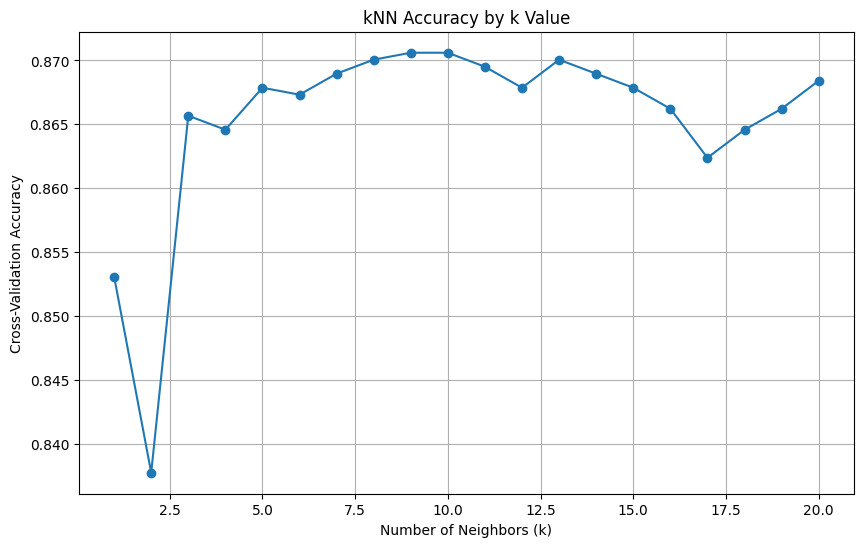

Best k value: 9 with accuracy: 0.871
Test Accuracy: 0.884

Classification Report:
              precision    recall  f1-score   support

    drifting       0.74      0.70      0.72        61
     fishing       0.29      0.24      0.26        21
        hook       0.53      0.46      0.49        39
     lobster       0.55      0.55      0.55        38
       seine       0.43      0.23      0.30        13
     stopped       0.97      0.99      0.98       351
     transit       0.95      0.98      0.96       247
       trawl       0.85      0.92      0.88        12

    accuracy                           0.88       782
   macro avg       0.66      0.63      0.64       782
weighted avg       0.87      0.88      0.88       782



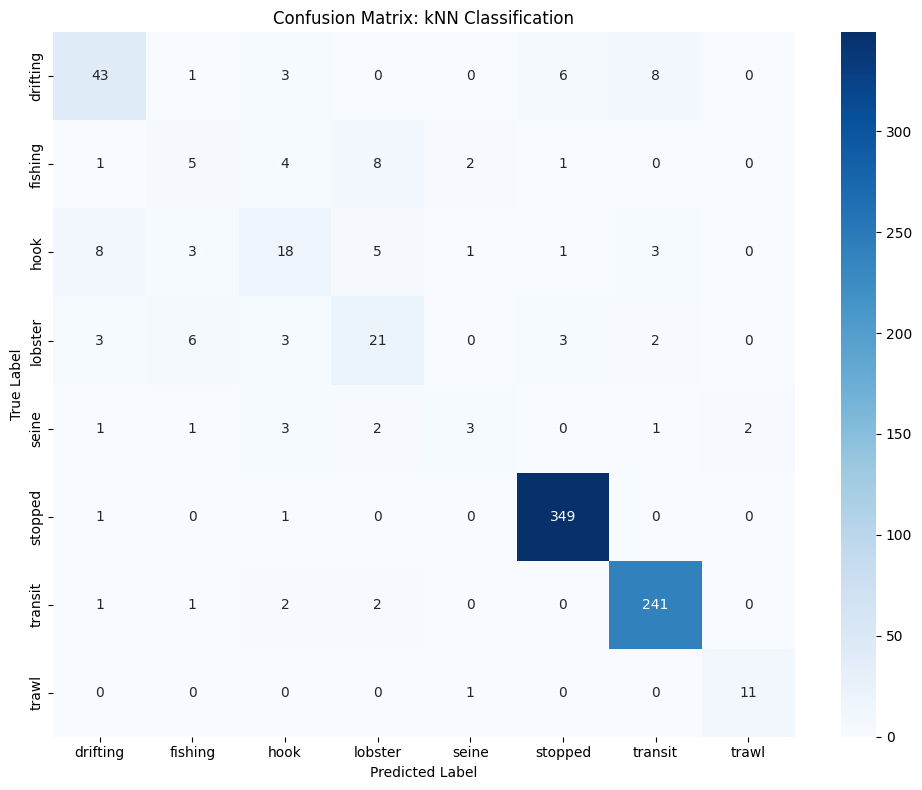

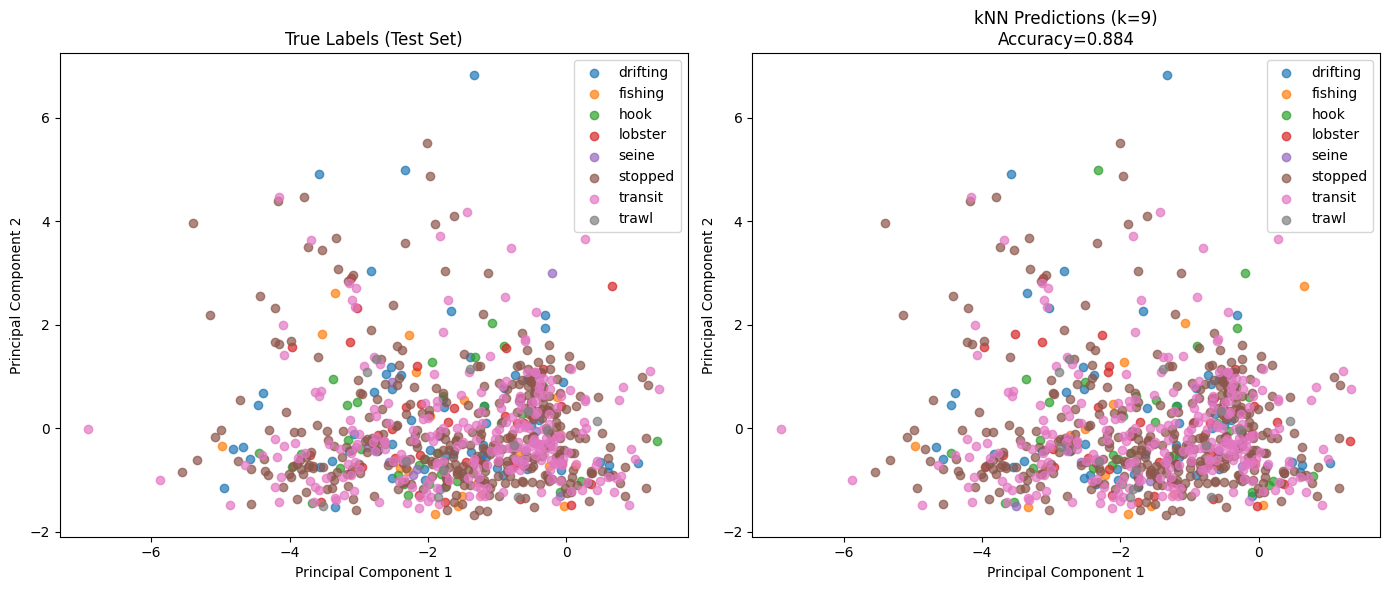


Comparison between kNN and GMM:
kNN (k=9) - ARI: 0.042, NMI: 0.041
GMM - ARI: 0.484, NMI: 0.560


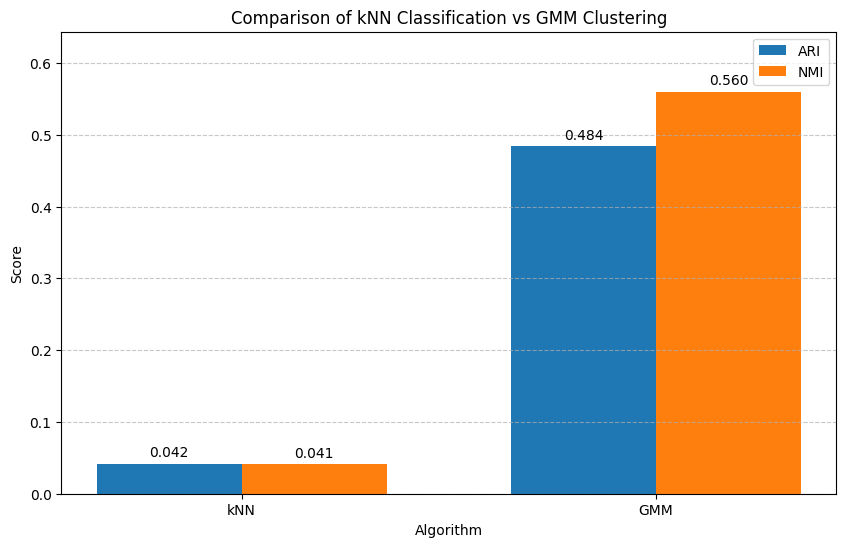

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# We also need to split the PCA-reduced data the same way
# Create train/test masks to select the right points
train_indices = X_train.index if hasattr(X_train, 'index') else np.arange(len(X_scaled))[~np.isin(np.arange(len(X_scaled)),
                                                                                         X_test.index if hasattr(X_test, 'index') else np.arange(len(X_test)))]
test_indices = X_test.index if hasattr(X_test, 'index') else np.arange(len(X_test))

# Use the masks to split PCA data
X_pca_train = X_pca[train_indices]
X_pca_test = X_pca[test_indices]

# Find the optimal k value
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot the accuracy vs k value
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.title('kNN Accuracy by k Value')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

# Select the best k value
best_k = k_range[np.argmax(k_scores)]
print(f"Best k value: {best_k} with accuracy: {np.max(k_scores):.3f}")

# Train the KNN classifier with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix: kNN Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Visualize the decision boundaries on PCA
plt.figure(figsize=(14, 6))

# Original test labels
plt.subplot(1, 2, 1)
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    # Fix: Use X_pca_test instead of indexing X_pca with X_test.index
    mask = np.array(y_test == label)
    plt.scatter(X_pca_test[mask, 0], X_pca_test[mask, 1],
                label=label, alpha=0.7)
plt.title('True Labels (Test Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# kNN predictions on test set
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    # Fix: Use X_pca_test instead of indexing X_pca with X_test.index
    mask = np.array(y_pred == label)
    plt.scatter(X_pca_test[mask, 0], X_pca_test[mask, 1],
                label=label, alpha=0.7)
plt.title(f'kNN Predictions (k={best_k})\nAccuracy={accuracy:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()

# Compare kNN with GMM and original labels
# Refit GMM on the entire dataset
gmm = GaussianMixture(
    n_components=len(np.unique(y)),
    covariance_type='full',  # Replace with your best covariance type
    random_state=42
)
gmm_labels = gmm.fit_predict(X_scaled)

# Calculate ARI and NMI for kNN predictions vs true labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Map predicted labels to original class numbers for fair comparison
def align_labels(true_labels, cluster_labels):
    """Align cluster labels to true labels based on maximum overlap."""
    from scipy.optimize import linear_sum_assignment

    # Convert to numeric labels if needed
    if not np.issubdtype(true_labels.dtype, np.number):
        true_numeric = pd.factorize(true_labels)[0]
    else:
        true_numeric = true_labels

    if not np.issubdtype(cluster_labels.dtype, np.number):
        cluster_numeric = pd.factorize(cluster_labels)[0]
    else:
        cluster_numeric = cluster_labels

    # Create contingency matrix
    contingency = confusion_matrix(true_numeric, cluster_numeric)

    # Find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(-contingency)

    # Create a mapping from cluster labels to true labels
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}

    # Apply the mapping to the cluster labels
    aligned_labels = np.array([mapping.get(label, label) for label in cluster_numeric])

    return aligned_labels

# Align labels for fair comparison
aligned_gmm_labels = align_labels(y_encoded, gmm_labels)

# Combine the train and test predictions from kNN
# First, make sure y_encoded exists or create it
if 'y_encoded' not in locals():
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

# Get predictions for all data
y_all_knn = np.zeros_like(y_encoded)
train_mask = np.zeros(len(y_encoded), dtype=bool)
train_mask[train_indices] = True
test_mask = np.zeros(len(y_encoded), dtype=bool)
test_mask[test_indices] = True

# Use factorize to get numeric versions if needed
train_preds = pd.factorize(knn.predict(X_train))[0] if not np.issubdtype(y_train.dtype, np.number) else knn.predict(X_train)
test_preds = pd.factorize(y_pred)[0] if not np.issubdtype(y_pred.dtype, np.number) else y_pred

y_all_knn[train_mask] = train_preds
y_all_knn[test_mask] = test_preds

# Calculate metrics
ari_knn = adjusted_rand_score(y_encoded, y_all_knn)
nmi_knn = normalized_mutual_info_score(y_encoded, y_all_knn)
ari_gmm = adjusted_rand_score(y_encoded, aligned_gmm_labels)
nmi_gmm = normalized_mutual_info_score(y_encoded, aligned_gmm_labels)

# Print comparison
print("\nComparison between kNN and GMM:")
print(f"kNN (k={best_k}) - ARI: {ari_knn:.3f}, NMI: {nmi_knn:.3f}")
print(f"GMM - ARI: {ari_gmm:.3f}, NMI: {nmi_gmm:.3f}")

# Plot bar chart comparison
plt.figure(figsize=(10, 6))
models = ['kNN', 'GMM']
ari_scores = [ari_knn, ari_gmm]
nmi_scores = [nmi_knn, nmi_gmm]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, ari_scores, width, label='ARI')
plt.bar(x + width/2, nmi_scores, width, label='NMI')

plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.title('Comparison of kNN Classification vs GMM Clustering')
plt.xticks(x, models)
plt.legend()

# Add value labels on bars
for i, v in enumerate(ari_scores):
    plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')

for i, v in enumerate(nmi_scores):
    plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

plt.ylim(0, max(max(ari_scores), max(nmi_scores)) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()